https://www.kaggle.com/code/daisypond/example-of-topic-modeling-for-tweets

https://www.kaggle.com/code/errearanhas/topic-modelling-lda-on-elon-tweets

## Importing libs

In [57]:
import pandas as pd
import os
from tqdm import tqdm 
import numpy as np
import pickle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

## Importing data

In [119]:
df = (
    pd.read_csv('tweets/all_tweets.csv')
    .iloc[:, 1:]
)

In [120]:
df.shape

(359036, 28)

In [123]:
df.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21+00:00,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,False
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27+00:00,[1617597646339702823],1617597646339702823,NaN,qme,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,False


## Preparing tweets

In [126]:
tweets = df.set_index('id')['text'].drop_duplicates()

In [127]:
tweets.shape

(304154,)

In [128]:
import re
from unidecode import unidecode
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk

In [129]:
tweets.head()

id
1617597872803041280    Kararlarındaki temel dayanak, hukukun evrensel...
1617597646339702823    #OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU
1617597571903676417    RT @Yozgat_KHK: #OhalKomisyonuHukuksuzdur\nÇün...
1617597543000440844    #OhalKomisyonuHukuksuzdur https://t.co/FHdc5DQ0u0
1617597477963829248    RT @Malatya_KHK: Öldükten sonra insanlari işe ...
Name: text, dtype: object

In [130]:
tweets = tweets.map(lambda x: re.sub('#[A-Za-z0-9]+', '', x))  # remove hashtag
tweets = tweets.map(lambda x: re.sub('https://t.co/[A-Za-z0-9]+', '', x)) # remove link
tweets = tweets.map(lambda x: re.sub('[,\.!?]', '', x)) # remove ,.!?
tweets = tweets.map(lambda x: re.sub('\n', '', x)) # remove \n
tweets = tweets.map(lambda x: unidecode(x)) # remove accents

stopwords = nltk.corpus.stopwords.words('turkish') 
stopwords = [unidecode(i) for i in stopwords] 
tweets = tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) # remove stopwords

In [131]:
tweets = tweets.str.lower() # lower all the words

In [132]:
tweets = tweets.drop_duplicates()

In [133]:
text_len = tweets.apply(lambda x: len(x))

In [134]:
tweets = tweets[text_len[text_len>5].index] # selecting only tweets that are greater than 5 chars

## Modeling

### Bag of words

In [74]:
# bow
vect = CountVectorizer(max_features=500000)
x = vect.fit_transform(tweets)

In [109]:
tweets.shape

(283912,)

In [108]:
x.shape

(283912, 345309)

### Topic modeling - LDA

In [75]:
topics = 30

In [76]:
# lda
lda = LatentDirichletAllocation(n_components = topics, learning_method="batch", max_iter=20, random_state=42)
document_topics = lda.fit_transform(x)

## Results

In [296]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print('\n')

In [298]:
display_topics(lda, feat_names, 30)

Topic 1:
turkiye nin rt de da in erdogan ye abd turk rusya iran ukrayna ya den kurt kurdistan dan yi suriye youtube bir savas avrupa son rojava araciligiyla artitv_ almanya karsi


Topic 2:
cocuk rt cocuklar anne cocuklarin cocuklari baba bile cocuklara bir cocuklarannesizkalmasin bebek cocugun cocugu kiz babasi annesi cezaevinde masum aile zorunda yasinda bu bebekler kalan birakmayin cezaevlerinde hasret ac birakin


Topic 3:
the rt to of in and is on for with this it turkey that are you as not by we from amp at was have be an my he will


Topic 4:
rt yoksulluk hacerfoggo once zam mtanal osman derin yavas gundur olarak tanal hacer kar yana tarim kavala foggo birbirimizi geiin aclik sanliurfa ozer bir odak kabul ezoozer odtu daysozgurluk savash_porgham


Topic 5:
rt khk bir ihrac binlerce insan edilen sivil ohal kamu mahkum olume hukuksuz ilan edildi masum yuzbinlerce insanlar magdur lar terorist insanin isinden bu terk insanlari haksiz olan gecede sosyal


Topic 6:
in rt gazeteci hapi

### Combine tweets with their main topics

In [143]:
df_topic = pd.DataFrame(
    document_topics, 
    columns=[f'topic_{str(i)}' for i in range(document_topics.shape[1])],
    index=tweets.index
)

In [168]:
df_topic.head(4).style.highlight_max(axis=1)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1617597872803041280,0.002778,0.002778,0.086111,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.836111,0.002778,0.002778
1617597571903676416,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.297032,0.003030,0.003030,0.003030,0.003030,0.003030,0.419121,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.003030,0.202029,0.003030
1617597477963829248,0.004167,0.004167,0.004167,0.004167,0.173268,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.518300,0.004167,0.195932,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167
1617597218038349824,0.004167,0.004167,0.004167,0.004167,0.457712,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.162181,0.004167,0.004167,0.267607,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167


In [164]:
top_topic = []

for _, i in tqdm(df_topic.T.items()):
    top_topic.append(i.idxmax())

283912it [01:18, 3609.94it/s]


In [170]:
df_topic['main_topic'] = top_topic

Topics seems to be relatively homogeneous

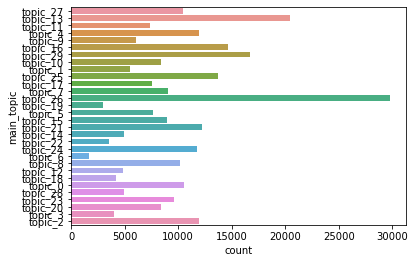

In [178]:
sns.countplot(data=df_topic, y='main_topic');

In [182]:
df_topic.shape

(283912, 31)

### Combine tweets metrics with their main topics

In [183]:
a = df.merge(df_topic.reset_index()[['id', 'main_topic']], on='id')

In [185]:
a.head(3)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,main_topic
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21+00:00,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,False,topic_27
1,1449804331142811655,NaN,1617597571903676417,2023-01-23 18:58:09+00:00,[1617597571903676417],1617597571903676417,NaN,tr,False,[<ReferencedTweet id=1617584897383714816 type=...,everyone,RT @Yozgat_KHK: #OhalKomisyonuHukuksuzdur\nÇün...,Goksun_KHK,NaN,NaN,0,48,0,0,0,NaN,NaN,"[{'start': 16, 'end': 41, 'tag': 'OhalKomisyon...",NaN,"[{'start': 3, 'end': 14, 'username': 'Yozgat_K...",NaN,NaN,True,topic_13
2,1449804331142811655,NaN,1617597477963829248,2023-01-23 18:57:46+00:00,[1617597477963829248],1617597477963829248,NaN,tr,False,[<ReferencedTweet id=1617597368417013761 type=...,everyone,RT @Malatya_KHK: Öldükten sonra insanlari işe ...,Goksun_KHK,NaN,NaN,0,4,0,0,0,NaN,NaN,"[{'start': 57, 'end': 82, 'tag': 'OhalKomisyon...",NaN,"[{'start': 3, 'end': 15, 'username': 'Malatya_...",NaN,NaN,True,topic_11


In [193]:
pd.crosstab(a['is_retweet'], a['main_topic'])

main_topic,topic_0,topic_1,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_2,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
is_retweet,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,6307,3247,5079,3430,4016,7470,3465,4252,8854,3582,2723,2102,4885,5662,5504,2324,4696,4319,8603,19359,5914,2853,9791,1490,5809,4478,1008,6293,4919,2725
True,4229,2263,3274,3950,851,12972,1499,4687,5754,3984,1450,872,7097,2691,6668,1219,4877,7415,5125,10456,4500,2089,6953,2490,6165,3148,662,2762,5286,3365


In [198]:
df.groupby('is_retweet')['like_count'].agg(['count', 'mean', 'median', 'sum'])

,count,mean,median,sum
is_retweet,,,,
False,176387,130.190343,6.0,22963884
True,182649,0.000077,0.0,14


In [199]:
df.groupby('is_retweet')['retweet_count'].agg(['count', 'mean', 'median', 'sum'])

,count,mean,median,sum
is_retweet,,,,
False,176387,29.211064,2.0,5152452
True,182649,248.565122,23.0,45400171


In [200]:
df.groupby('is_retweet')['reply_count'].agg(['count', 'mean', 'median', 'sum'])

,count,mean,median,sum
is_retweet,,,,
False,176387,5.271749,0.0,929868
True,182649,0.000005,0.0,1


Topics 17, 23 and 24 seem to present higher likes

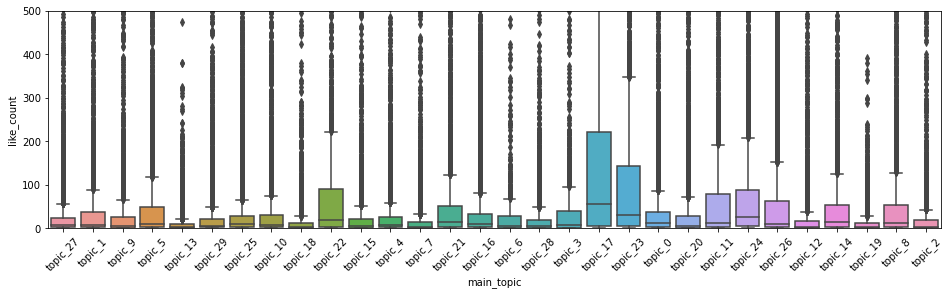

In [299]:
plt.figure(figsize=(16, 4))
plt.ylim(0, 500)
plt.xticks(rotation=45)
sns.boxplot(data=a[a['is_retweet']==False], x='main_topic', y='like_count');

Topics 17 and 23 seem to present higher retweets

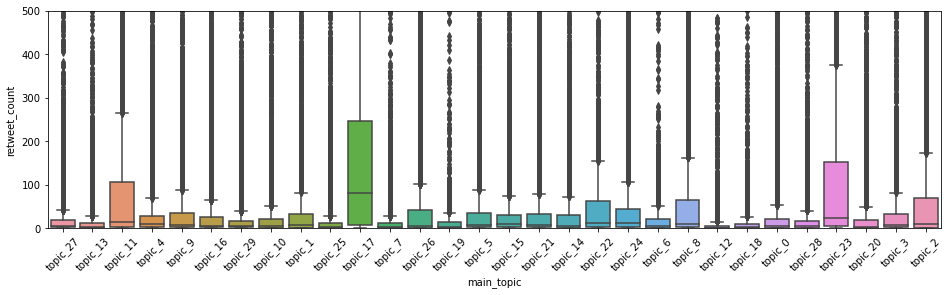

In [300]:
plt.figure(figsize=(16, 4))
plt.ylim(0, 500)
plt.xticks(rotation=45)
sns.boxplot(data=a, x='main_topic', y='retweet_count');

## Running classifier

In [210]:
from sklearn.linear_model import LogisticRegressionCV

In [301]:
lr = LogisticRegression()

### Predicting higher likes

In [302]:
x = pd.get_dummies(a[a['is_retweet']==False]['main_topic'], drop_first=True)

In [303]:
y = a[a['is_retweet']==False]['like_count']

In [304]:
y.describe()

count    155159.000000
mean        144.798864
std        1034.535446
min           0.000000
25%           2.000000
50%           8.000000
75%          35.000000
max       73017.000000
Name: like_count, dtype: float64

In [305]:
y = np.where(y>y.median(), 1, 0)

In [306]:
lr.fit(x, y)

LogisticRegression()

In [307]:
from sklearn.metrics import classification_report, f1_score

In [308]:
y_pred = lr.predict(x)

In [309]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.57      0.59     79553
           1       0.58      0.61      0.59     75606

    accuracy                           0.59    155159
   macro avg       0.59      0.59      0.59    155159
weighted avg       0.59      0.59      0.59    155159



In [310]:
res = pd.DataFrame(lr.coef_, columns=lr.feature_names_in_, index=['coef'])

As already seen, topics 17, 23 and 24 contribute to higher likes

<AxesSubplot:>

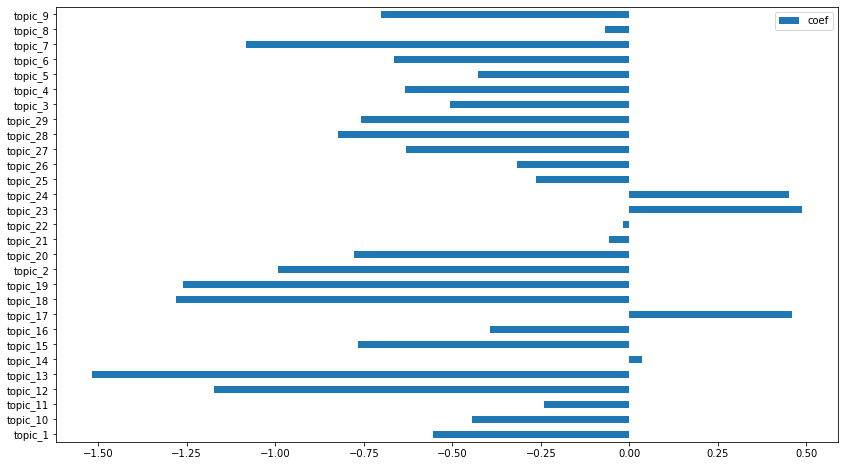

In [285]:
res.T.plot.barh(figsize=(14, 8))

### Predicting higher retweets

In [286]:
x = pd.get_dummies(a['main_topic'], drop_first=True)

In [287]:
y = a['retweet_count']

In [288]:
y.describe()

count    283912.000000
mean        127.722840
std        1824.605264
min           0.000000
25%           1.000000
50%           6.000000
75%          29.000000
max      570083.000000
Name: retweet_count, dtype: float64

In [289]:
y = np.where(y>y.median(), 1, 0)

In [290]:
lr.fit(x, y)

LogisticRegression()

In [291]:
from sklearn.metrics import classification_report, f1_score

In [292]:
y_pred = lr.predict(x)

In [293]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.66      0.61    142072
           1       0.59      0.49      0.53    141840

    accuracy                           0.57    283912
   macro avg       0.58      0.57      0.57    283912
weighted avg       0.58      0.57      0.57    283912



In [294]:
res = pd.DataFrame(lr.coef_, columns=lr.feature_names_in_, index=['coef'])

<AxesSubplot:>

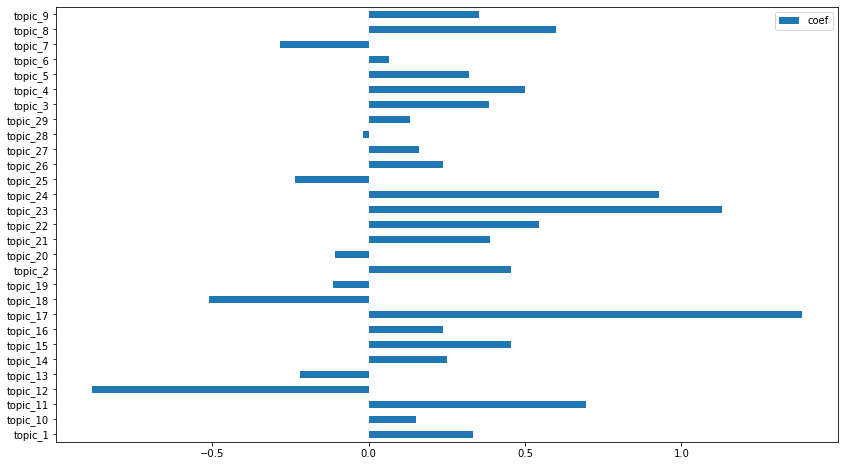

In [295]:
res.T.plot.barh(figsize=(14, 8))